# **Project 3** : Implementing clustering analysis using 3 models

In [0]:
#Import libraries for all three parts of the experiment
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import mixture

from keras.layers import MaxPool2D,Activation
from keras import backend as K
from sklearn.cluster import KMeans
import seaborn as sns
from keras import callbacks
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

import keras
from matplotlib import pyplot as plt
import gzip
import os
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, normalized_mutual_info_score,confusion_matrix,classification_report

Installing CoClust library for the purpose of accuracy calculation

In [95]:
!pip install coclust
from coclust.evaluation.external import accuracy

Using the LOAD_MNIST method provided 

In [0]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Mount Data from Google Drive

In [97]:
from google.colab import drive
drive.mount('/content/drive')

X_train, y_train = load_mnist('/content/drive/My Drive/Colab Notebooks/data/fashion', kind='train')
X_data, y_data = load_mnist('/content/drive/My Drive/Colab Notebooks/data/fashion', kind='t10k')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Naive KMeans Implementation

In [98]:
x = np.concatenate((X_train,X_data))
y = np.concatenate((y_train,y_data))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255)

n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters=10, init='random', n_init=10, max_iter=100, tol=1e-04, random_state=0, algorithm = 'elkan')
kmeans.fit(x)
print('SSE for clusters = ', '10' ,'is', kmeans.inertia_)

predictions = kmeans.predict(X_data)
np_predictions = np.argmax(predictions)

SSE for clusters =  10 is 2233496.1077513914


In [100]:
from coclust.evaluation.external import accuracy
from sklearn.utils.linear_assignment_ import linear_assignment
print(accuracy(y, kmeans.labels_))

cm = confusion_matrix(y,kmeans.labels_)

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

print(cm2)

0.5398571428571428
[[4001  199  208   23   47  508 1977    3   34    0]
 [ 285 6298   30    2   55  148  182    0    0    0]
 [  98   12 2168   23 2178  473 2020    1   27    0]
 [1987 3636   20    5   66  487  787    0   11    1]
 [ 817  173 1096   15 3561  230 1077    0   31    0]
 [   3    1    0   13    0 4680   58 1672   12  561]
 [1224   61 1071   56 1404  729 2428    6   19    2]
 [   0    0    0    6    0  724    1 5929    0  340]
 [  24   24  346 2508   45  496  379  333 2837    8]
 [   8    3    2    7   11  235   69  777    5 5883]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [ ]:
# loss = []
# for n in range(1,20):
#     kmeans = KMeans(n_clusters=n, init='random', n_init=10, n_jobs=5)
#     kmeans.fit(x)
#     print('SSE is', kmeans.inertia_)
#     loss.append(kmeans.inertia_)

# plt.plot(range(1,20), loss, marker='x')
# plt.ylabel('SSE')
# plt.xlabel('Clusters')

Split into Validation and Test for AutoEncoder

In [0]:
X_validation, X_test, y_validation, y_test = train_test_split(X_data, y_data, test_size=0.50, shuffle=False)

In [7]:
batch_size = 64
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10 #given in the problem statement

Data Pre-Processing step

In [0]:
X_train = X_train.reshape(-1, 28,28, 1)/255
X_test = X_test.reshape(-1, 28,28, 1)/255
X_validation = X_validation.reshape(-1, 28,28, 1)/255

# Convolutional AutoEncoder - Encoder and Decoder definitions



In [0]:
def encoder(input_image):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(7, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(7, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)
    decoded_image = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded_image

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Fit the training and validation data 

In [12]:
autoencoder_train = autoencoder.fit(X_train,X_train, batch_size=batch_size,epochs=45,verbose=1,validation_data=(X_validation, X_validation))



Train on 60000 samples, validate on 5000 samples
Epoch 1/45
60000/60000 [==============================] - 20s 330us/step - loss: 0.0182 - val_loss: 0.0148
Epoch 2/45
60000/60000 [==============================] - 16s 273us/step - loss: 0.0088 - val_loss: 0.0163
Epoch 3/45
60000/60000 [==============================] - 16s 273us/step - loss: 0.0072 - val_loss: 0.0082
Epoch 4/45
60000/60000 [==============================] - 16s 273us/step - loss: 0.0060 - val_loss: 0.0058
Epoch 5/45
60000/60000 [==============================] - 16s 271us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 6/45
60000/60000 [==============================] - 16s 272us/step - loss: 0.0050 - val_loss: 0.0057
Epoch 7/45
60000/60000 [==============================] - 16s 270us/step - loss: 0.0045 - val_loss: 0.0070
Epoch 8/45
60000/60000 [==============================] - 16s 267us/step - loss: 0.0042 - val_loss: 0.0050
Epoch 9/45
60000/60000 [==============================] - 16s 267us/step - loss: 0.0039 - val

Plot the resulting Training and Validation losses versus Epochs

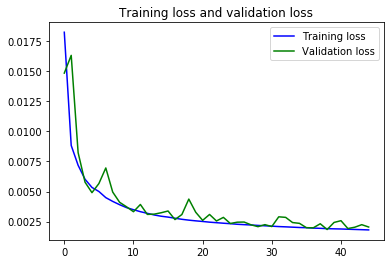

In [89]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(45)
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss and validation loss')
plt.legend()
plt.show()

In [0]:
autoencoder.save_weights('autoencoder.h5')
weights = autoencoder.get_weights()
encode = Model(input_img,encoder(input_img))

In [0]:
for l1,l2 in zip(encode.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

predicted_encode = encode.predict(X_test)

# AutoEncoder + KMeans

In [0]:
kmeans_with_autoencoder = KMeans(n_clusters=10)
predicted_encode = predicted_encode.reshape(-1,7*7*7)
clustered_training_set = kmeans_with_autoencoder.fit_predict(predicted_encode)

Obtaining the accuracy of the KMeans + AutoEncoder Model using CoClust

In [88]:
print ("CoClust Accuracy: ")
accuracy(y_test, clustered_training_set)

CoClust Accuracy: 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.5656

Plot the confusion matrix

In [87]:
cm = confusion_matrix(y_test,clustered_training_set)
from sklearn.utils.linear_assignment_ import linear_assignment

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

print(cm2)

[[284   0   6  51   5   0 137   0  10   0]
 [  0 429   2  54   7   0  26   0   1   0]
 [ 13   0 164   3 130   0 159   0  10   0]
 [  8  18   0 334  10   0 129   0   1   0]
 [  1   1 125  47 229   0  73   0   3   0]
 [  0   0   0   0   0 121  31 261   1 101]
 [ 62   0  87  48  89   0 206   0  26   0]
 [  0   0   0   0   0   1   0 408   1  90]
 [  0   0   8   5   5   0  93   6 356   1]
 [  0   0   2   0   1 211   0  11   1 297]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


# AutoEncoder + GMM

In [0]:
gmm = mixture.GaussianMixture(n_components=10, init_params='kmeans', max_iter=300).fit(pred_encode)
labels_gmm = gmm.predict(pred_encode)

Obtain the accuracy of the GMM + AutoEncoder Model using CoClust

In [84]:
accuracy(y_test,labels_gmm)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.5876

Plot the confusion matrix

In [85]:
cm = confusion_matrix(y_test,labels_gmm)
from sklearn.utils.linear_assignment_ import linear_assignment

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [86]:
print(cm2)

[[285   1   0  54   4   1 139   0   9   0]
 [  0 433   0  48   7   1  29   0   1   0]
 [ 25   0   0   6 273   0 162   0  13   0]
 [  3  80   0 274   7   0 135   0   1   0]
 [  2   1   0  63 331   0  78   0   4   0]
 [  0   0  27   0   0 368   6  87   1  26]
 [ 58   2   0  52 171   2 208   0  25   0]
 [  0   0   1   0   0  41   0 380   1  77]
 [  1   0   0   3  10  17  87   4 352   0]
 [  0   0 182   0   1  19   1  12   1 307]]
